# text assignment CO2

This is your final assignment. You'll get a lot of freedom in doing this assignment but that also means you have to make choices and explain the reasoning behind those choices in your report.


For this assignment you can use any dataset you can find from the [Our World in Data website](https://ourworldindata.org/)

Please formulate an answer to the following three questions in your report.

1. What is the biggest predictor of a large CO2 output per capita of a country?
2. which countries are making the biggest strides in decreasing CO2 output?
3. which non-fossil fuel energy technology will have the best price in the future?


1. Biggest predictor of CO2 output

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors.


2. Biggest strides in decreasing CO2 output

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.


3. Best future price for non-fossil fuel energy

To be able to predict prices you'll probably need to use linear regression over the various non-fossil fuel options.

# Installations

In [303]:
pip install fpdf

# imports

In [304]:
import numpy as np
import numpy.polynomial.polynomial as poly # import voor regressielijn
from functools import reduce
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.mathtext import FontProperties
from matplotlib.layout_engine import ConstrainedLayoutEngine
import missingno as msno
from sklearn.impute import KNNImputer # import voor KNN imputation
from sklearn.cluster import KMeans
from fpdf import FPDF
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import lognorm

In [305]:
# %load_ext google.colab.data_table

# Dataframe

## Raw dataframes

In [306]:
url_co2_data = "https://raw.githubusercontent.com/PetraHartman/module_7/main/owid-co2-data.csv"
df_co2_data = pd.read_csv(url_co2_data, encoding = "iso-8859-1")
# display (df_co2_data)

In [307]:
url_energy_cost = "https://raw.githubusercontent.com/PetraHartman/module_7/main/levelized-cost-of-energy.csv"
df_energy_cost = pd.read_csv(url_energy_cost, encoding = "iso-8859-1")
# display(df_energy_cost)

## Modified/ cleaned dataframes

### 1.What is the biggest predictor of a large CO2 output per capita of a country?

In [308]:
# keep columns
capita_columns = [col for col in df_co2_data if "capita" in col]
df_co2_data_predictor_a = df_co2_data[["country",
                                       "year",
                                       "iso_code",
                                       "gdp",
                                       "population"]]
df_co2_data_predictor_b = df_co2_data[capita_columns]
df_predictor = pd.concat([df_co2_data_predictor_a, df_co2_data_predictor_b],
                               axis = 1)

# capitalize column names
df_predictor.columns = [s.capitalize() for s in df_predictor.columns]

# change column names
df_predictor.columns = df_predictor.columns.str.replace("_", " ")
df_predictor.columns = df_predictor.columns.str.replace("per capita", "(per capita)")
df_predictor.columns = df_predictor.columns.str.replace("co2", "CO2")
df_predictor.columns = df_predictor.columns.str.replace("Co2", "CO2")

# add gdp per catipa
if "GDP (per capita)" not in df_predictor:
  df_predictor['GDP (per capita)'] = df_predictor["Gdp"] / df_predictor["Population"]

# drop columns because combined are CO2 including luc (per capita)
df_predictor = df_predictor.drop("CO2 (per capita)", axis = 1)
df_predictor = df_predictor.drop("Land use change CO2 (per capita)", axis = 1)
# drop column because is similar to Ghg (per capita)
df_predictor = df_predictor.drop("Ghg excluding lucf (per capita)", axis = 1)

# drop columns that have been recalcutated to (per capita)
df_predictor = df_predictor.drop("Gdp", axis = 1)


# rename column to clarify name
df_predictor = df_predictor.rename(columns = {"Other CO2 (per capita)" : "Other industries CO2 (per capita)" })

In [309]:
# drop NaN values
df_predictor = df_predictor.dropna()
# display(df_predictor)

In [310]:
def contributing_countries():
    year_list = pd.unique(df_predictor["Year"])
    grp_data = df_predictor.groupby(["Year"])
    df_contributing = pd.DataFrame(columns = ["Year",
                                          "Number of data contributing countries"])
    for year in year_list:
        if year not in df_contributing:
           length = len (grp_data.get_group(year))

           row = {"Year" : [year],  "Number of data contributing countries" : [length]}
           df_row = pd.DataFrame(row)
           df_contributing = pd.concat([df_contributing, df_row], axis = 0)

           df_contributing["Number of data contributing countries"]= df_contributing["Number of data contributing countries"].astype(int)
    return (df_contributing)

df_year = contributing_countries()

In [311]:
# max number of data contributing countries
max_countries_year = df_year["Number of data contributing countries"].max()
df_year = df_year.loc[df_year["Number of data contributing countries"] == df_year["Number of data contributing countries"].max()]

first_year = df_year["Year"].min()
last_year = df_year["Year"].max()
# list of all countries in years of maximum contributing countries
df_predictor= df_predictor.loc[(df_predictor["Year"] <= df_year["Year"].max()) & (df_predictor["Year"] >= df_year["Year"].min())]
# display (df_reduction)

# number of unique countries in years of maximum data contributing countries
unique_country_list = []
for country in df_predictor["Country"]:
  # unique_country_list = []
  if country not in unique_country_list:
    unique_country_list.append(country)
# display(len(unique_country_list) == df_year["Number of data contributing countries"].max())

f"""each year from {first_year} till {last_year} consists out of the same {max_countries_year} data contributing countries."""

'each year from 2003 till 2018 consists out of the same 43 data contributing countries.'

filter df_predictor to only the years where the max number of countries contributed in the data. The assumption is made that all deliver the data unther the same conditions.

In [312]:
mask_year = df_predictor.Year >= first_year
df_predictor = df_predictor[mask_year]

Identify outliers by IQR method

In [313]:
df = df_predictor
column_names = [col for col in df.columns if "capita" in col]

for column_name in column_names:
# calcultate upper and lower limits
    q_1 = np.percentile(df[column_name], 25, method = "midpoint")
    q_3 = np.percentile(df[column_name], 75, method = "midpoint")

    iqr = q_3 - q_1

    upper = round(q_3 + 1.5 * iqr, 4)
    lower = round(q_1 - 1.5 * iqr, 4)

# determine outliers
    upper_array = list(np.where(df[column_name] >= upper) [0])
    lower_array = list (np.where(df[column_name] <= lower) [0])
    outlier_list = upper_array + lower_array

# calculate mean
    mean = round(df[column_name].mean(),4)

    for item in outlier_list:
        change_value = df[column_name].iloc[item]
        df[column_name] = df[column_name].replace({change_value : mean})

display(df_predictor)

,Country,Year,Iso code,Population,Cement CO2 (per capita),CO2 including luc (per capita),Coal CO2 (per capita),Consumption CO2 (per capita),Energy (per capita),Flaring CO2 (per capita),Gas CO2 (per capita),Ghg (per capita),Methane (per capita),Nitrous oxide (per capita),Oil CO2 (per capita),Other industries CO2 (per capita),GDP (per capita)
3751,Australia,2003,AUS,19699004.0,0.182,8.8002,2.6917,16.993,69082.789,0.0965,2.523,9.6256,1.4626,0.7567,5.562,0.198,39284.657119
3752,Australia,2004,AUS,19925060.0,0.178,8.8002,2.6917,17.292,70486.320,0.0965,2.636,9.6256,1.4626,0.7567,5.710,0.196,40623.201889
3753,Australia,2005,AUS,20171732.0,0.182,8.8002,2.6917,17.051,69917.164,0.0965,2.701,9.6256,1.4626,0.7567,5.776,0.193,41669.925910
3754,Australia,2006,AUS,20467032.0,0.190,8.8002,2.6917,17.410,71863.758,0.0965,2.727,9.6256,1.4626,0.7567,5.736,0.188,42450.659090
3755,Australia,2007,AUS,20830832.0,0.191,8.8002,2.6917,17.677,72304.695,0.0965,2.931,9.6256,1.4626,0.7567,5.735,0.196,43871.308717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48151,United States,2014,USA,322033952.0,0.122,17.2710,5.3110,18.142,80725.086,0.1990,4.456,17.9470,2.0820,0.8140,6.979,0.101,51182.996422
48152,United States,2015,USA,324607776.0,0.123,16.6330,4.5560,17.852,79317.367,0.2010,4.547,17.4520,2.0690,0.8040,7.040,0.096,52070.775112
48153,United States,2016,USA,327210208.0,0.121,16.2370,4.1190,17.310,78613.539,0.1670,4.528,17.5540,1.9960,0.8170,7.028,0.088,52451.166787
48154,United States,2017,USA,329791232.0,0.122,16.0010,3.9680,17.088,78289.008,0.1800,4.428,17.2520,2.0310,0.8100,7.019,0.084,53355.826875


looking if data is distributed normal. this is done with the Shapiro wilk test. If the Shapiro Wilk test gives a P-value smaller than 0.05 the data is not distributed normal.

In [314]:
def shapiro_wilk():
  capita_columns = [col for col in df_predictor if "capita" in col]
  df_normal = pd.DataFrame(columns = ["Variable"])
  for name in capita_columns:  # takes all columns except for "Population"
       a = df_predictor[capita_columns[0]]
       b = df_predictor[name]
       shapiro_wilk = shapiro(b)
       shapiro_value = shapiro_wilk[0]
       p_value = shapiro_wilk[1]

       if p_value < 0.05:  # if p-value is smaller than 0.05 the data is not distributed normal.
          normal = "No"
       else:
          normal = "Yes"
       row = {"Variable" : name, "Shapiro" : shapiro_value, "P-value" : p_value, "Normal distributed": normal}
       df_row = pd.DataFrame(row, index=[0])
       df_normal = pd.concat([df_normal, df_row])
  if "Population" in df_predictor:  # taken seperately for there is no "capita" in the description.
       a = df_predictor[capita_columns[0]]
       b = df_predictor["Population"]
       shapiro_wilks = shapiro(b)
       shapiro_value = shapiro_wilks[0]
       p_value = shapiro_wilks[1]

       if p_value < 0.05:  # if p-value is smaller than 0.05 the data is not distributed normal.
          normal = "No"
       else:
          normal = "Yes"
       row = {"Variable" : "Population", "Shapiro" : shapiro_value, "P-value" : p_value, "Normal distributed": normal}
       df_row = pd.DataFrame(row, index=[0])
       df_normal = pd.concat([df_normal, df_row])
  return(df_normal)

df_shapiro = shapiro_wilk()
df_shapiro

# fig, ax = plt.subplots()
# fig.patch.set_visible(False)
# ax.axis('off')
# ax.axis('tight')

# ax.table(cellText = df_shapiro.values, colLabels = df_shapiro.columns, loc = "center")
# fig.tight_layout()
# plt.savefig("shapiro.png", transparent = False, facecolor = "white", bbox_inches = "tight")

,Variable,Shapiro,P-value,Normal distributed
0,Cement CO2 (per capita),0.980538,6.313118e-08,No
0,CO2 including luc (per capita),0.967509,3.209672e-11,No
0,Coal CO2 (per capita),0.910336,1.046196e-19,No
0,Consumption CO2 (per capita),0.963302,4.231827e-12,No
0,Energy (per capita),0.967618,3.390536e-11,No
0,Flaring CO2 (per capita),0.877033,6.975323e-23,No
0,Gas CO2 (per capita),0.960572,1.231572e-12,No
0,Ghg (per capita),0.975659,2.777848e-09,No
0,Methane (per capita),0.961851,2.179588e-12,No
0,Nitrous oxide (per capita),0.945643,3.398593e-15,No


Since non of the data is distributed normal. the data needs to be normalized.
this is done by taking the cubic root of the data.

https://www.statology.org/normality-test-python/

In [315]:
# normalize data
capita_columns = [col for col in df_predictor if "capita" in col]
df_predictor_normalized = pd.DataFrame(columns =[])
for name in capita_columns:
    df_predictor_normalized[name] = np.cbrt(df_predictor[name])
df_predictor_normalized["Population"] = np.cbrt(df_predictor["Population"])
display(df_predictor_normalized)

,Cement CO2 (per capita),CO2 including luc (per capita),Coal CO2 (per capita),Consumption CO2 (per capita),Energy (per capita),Flaring CO2 (per capita),Gas CO2 (per capita),Ghg (per capita),Methane (per capita),Nitrous oxide (per capita),Oil CO2 (per capita),Other industries CO2 (per capita),GDP (per capita),Population
3751,0.566705,2.064576,1.391048,2.570929,41.032057,0.458679,1.361358,2.127205,1.135120,0.911258,1.771782,0.582848,33.994422,270.073158
3752,0.562523,2.064576,1.391048,2.585920,41.308074,0.458679,1.381386,2.127205,1.135120,0.911258,1.787360,0.580879,34.376214,271.102307
3753,0.566705,2.064576,1.391048,2.573850,41.196590,0.458679,1.392649,2.127205,1.135120,0.911258,1.794220,0.577900,34.668968,272.216469
3754,0.574890,2.064576,1.391048,2.591789,41.575420,0.458679,1.397103,2.127205,1.135120,0.911258,1.790069,0.572865,34.884150,273.538392
3755,0.575897,2.064576,1.391048,2.604971,41.660278,0.458679,1.431106,2.127205,1.135120,0.911258,1.789965,0.580879,35.269031,275.149591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48151,0.495968,2.584873,1.744719,2.627615,43.218482,0.583827,1.645565,2.618167,1.276910,0.933702,1.911016,0.465701,37.128600,685.436490
48152,0.497319,2.552644,1.657784,2.613539,42.965786,0.585777,1.656692,2.593871,1.274247,0.929862,1.916568,0.457886,37.342038,687.257740
48153,0.494609,2.532223,1.602989,2.586817,42.838322,0.550688,1.654381,2.598915,1.259081,0.934847,1.915478,0.444796,37.432749,689.089472
48154,0.495968,2.519895,1.583157,2.575711,42.779292,0.564622,1.642111,2.583924,1.266397,0.932170,1.914660,0.437952,37.646732,690.896567


An example of the original versus the normalized data  for the "CO2 including luc (per capita). Be aware that normalized data does not have to match the normal distribution, but is coming close(r) to the normal distribution.


Since the graphs are placed in a PDF report with subtitles for the graphs, there is no title used in the code.

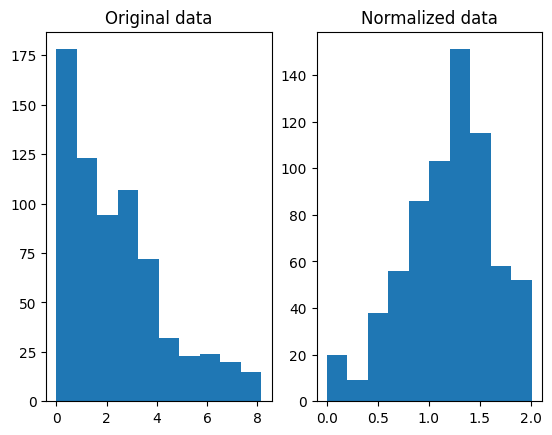

In [316]:
example_predictor_original = df_predictor["Coal CO2 (per capita)"]
example_predictor_normalized = df_predictor_normalized["Coal CO2 (per capita)"]

fig, ax = plt.subplots(nrows = 1, ncols = 2)

ax[0].hist(example_predictor_original)
ax[1].hist(example_predictor_normalized)
ax[0].set_title("Original data")
ax[1].set_title("Normalized data")
plt.savefig("histograms_original_normalized.png", transparent = False, facecolor = "white", bbox_inches = "tight")

### 2.Which countries are making the biggest strides in decreasing CO2 output?

In [317]:
# kept iso_code column so I could filter out nan (not countries.)
df_co2_reduction = df_co2_data[["country",
                                "iso_code",
                                "year",
                                "population",
                                "co2"]]

# drop NaN
df_co2_reduction = df_co2_reduction.dropna()

# drop Iso code (not needed anymore)
df_co2_reduction = df_co2_reduction.drop("iso_code", axis = 1)

# df_co2_reduction

In [318]:
def contributing_countries():
    year_list = pd.unique(df_co2_reduction["year"])
    grp_data = df_co2_reduction.groupby(["year"])
    df_contributing = pd.DataFrame(columns = ["Year",
                                          "Number of data contributing countries"])
    for year in year_list:
        if year not in df_contributing:
           length = len (grp_data.get_group(year))

           row = {"Year" : [year],  "Number of data contributing countries" : [length]}
           df_row = pd.DataFrame(row)
           df_contributing = pd.concat([df_contributing, df_row], axis = 0)

           df_contributing["Number of data contributing countries"]= df_contributing["Number of data contributing countries"].astype(int)
    return (df_contributing)

df_year = contributing_countries()

In [319]:
df_year

,Year,Number of data contributing countries
0,1949,114
0,1950,174
0,1951,176
0,1952,177
0,1953,177
...,...,...
0,1911,77
0,1912,77
0,1913,80
0,1914,74


In [320]:
# max number of data contributing countries
max_countries_year = df_year["Number of data contributing countries"].max()
df_year = df_year.loc[df_year["Number of data contributing countries"] == df_year["Number of data contributing countries"].max()]

first_year = df_year["Year"].min()
last_year = df_year["Year"].max()
# list of all countries in years of maximum contributing countries
df_reduction= df_co2_reduction.loc[(df_co2_reduction["year"] <= df_year["Year"].max()) & (df_co2_reduction["year"] >= df_year["Year"].min())]
# display (df_reduction)

# number of unique countries in years of maximum data contributing countries
unique_country_list = []
for country in df_reduction["country"]:
  # unique_country_list = []
  if country not in unique_country_list:
    unique_country_list.append(country)
# display(len(unique_country_list) == df_info_year["Number of data contributing countries"].max())

f"""each year from {first_year} till {last_year} consists out of the same {max_countries_year} data contributing countries."""

'each year from 2002 till 2021 consists out of the same 218 data contributing countries.'

filter df_co2_reduction to only the years where 218 countries contributed in the data. The assumption is made that all deliver the data unther the same conditions.

In [321]:
mask_year = df_co2_reduction.year >= first_year
df_co2_reduction = df_co2_reduction[mask_year]

Identify outliers by IQR method

In [322]:
country_group = df_co2_reduction.groupby("country")

country = "Germany"
country_data = country_group.get_group(country)
q1 = np.percentile(country_data["co2"], 25, method = "midpoint")
q3 = np.percentile(country_data["co2"], 75, method = "midpoint")
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

array_upper = list(np.where(country_data["co2"] >= upper)[0])
array_lower = list(np.where(country_data["co2"] <= lower)[0])

f"""Since the {len(array_lower) + len(array_upper)} datapoints marked as outliers are valid data because of the CO2 reduction achieved by {country}, but marked as outliers by the IQR method, it is not possible to descard of the outliers in the dataset by statistics."""

'Since the 2 datapoints marked as outliers are valid data because of the CO2 reduction achieved by Germany, but marked as outliers by the IQR method, it is not possible to descard of the outliers in the dataset by statistics.'

Since it is not possible to filter out the outliers, the data is evened out by using the rolling mean over a period of 3 years. This reduces the outliers, however the total reduction will also be altered.

In [323]:
country_group = df_co2_reduction.groupby("country")
rolling_data = pd.DataFrame(columns = ["country"])

country_list = []
for country in df_co2_reduction["country"]:
  unique_country_list = []
  if country not in unique_country_list:
    country_list.append(country)

for country in country_list:
    country_data = country_group.get_group(country)
    rolling_country_data = pd.DataFrame(columns = ["country"])
    rolling_country_data = pd.concat([rolling_country_data, country_data], axis = 0)
    rolling_country_data["co2_rolling"] = rolling_country_data["co2"].rolling(3).mean()
    rolling_country_data["co2_capita_rolling"] = rolling_country_data["co2_rolling"]/rolling_country_data["population"] * 1000000 # in ton CO2
    rolling_country_data = rolling_country_data.dropna()
    rolling_data = pd.concat([rolling_country_data, rolling_data], axis = 0)

# display (rolling_data)

df_co2_reduction = rolling_data
df_co2_reduction = df_co2_reduction.drop("co2", axis = 1)
df_co2_reduction


,country,year,population,co2_rolling,co2_capita_rolling
50580,Zimbabwe,2004.0,12160885.0,10.645000,0.875347
50581,Zimbabwe,2005.0,12224758.0,10.245667,0.838108
50582,Zimbabwe,2006.0,12330490.0,10.164000,0.824298
50583,Zimbabwe,2007.0,12450566.0,10.299333,0.827218
50584,Zimbabwe,2008.0,12550353.0,9.306667,0.741546
...,...,...,...,...,...
167,Afghanistan,2017.0,35643420.0,9.575667,0.268652
168,Afghanistan,2018.0,36686788.0,9.918000,0.270343
169,Afghanistan,2019.0,37769496.0,10.589333,0.280367
170,Afghanistan,2020.0,38972236.0,11.194000,0.287230


### 3.Which non-fossil fuel energy technology will have the best price in the future?

In [324]:
df_energy_cost = df_energy_cost.sort_values(by = ["Year"])
# display(df_energy_cost)
df_energy_cost_world = df_energy_cost.groupby("Entity").get_group("World")
# display(df_energy_cost_world)

# Analysis

## 1.What is the biggest predictor of a large CO2 output per capita of a country?

test for correlation between CO2 including luc (per capita) and other datasets. Normalized data is used.

In [325]:
# find correlation between total co2 per capita and parts of total co2 per capita
capita_columns = [col for col in df_predictor_normalized if "capita" in col]
# display (capita_columns)
df_pearsonr = pd.DataFrame(columns = ["Variable", "Pearsonr", "P-value"])
# for columns with capita in the name
for column in capita_columns:
  pearson_r_value = pearsonr(df_predictor_normalized["CO2 including luc (per capita)"], df_predictor_normalized[column])
  n = len(df_predictor_normalized[column])
  row = {"Variable" : column, "Pearsonr" : pearson_r_value[0], "P-value" : pearson_r_value[1], "N" : n}
  # display(row)
  df_row = pd.DataFrame(row, index = [0])
  df_pearsonr = pd.concat([df_pearsonr, df_row])
# for population (has no capita in column name)
pearson_r_value = pearsonr(df_predictor_normalized["CO2 including luc (per capita)"], df_predictor_normalized["Population"])
n = len(df_predictor_normalized["Population"])
row = {"Variable" : "Population", "Pearsonr" : pearson_r_value[0], "P-value" : pearson_r_value[1], "N" : n}
df_row = pd.DataFrame(row, index = [0])
df_pearsonr = pd.concat([df_pearsonr, df_row])
# drop column CO2 including luc (per capita) since this is the reference
df_pearsonr = df_pearsonr[(df_pearsonr.Variable != "CO2 including luc (per capita)")]
# df[((df.Name != 'jhon')

# only use significant values (P>0.05) and sort descending
df_pearsonr = df_pearsonr[df_pearsonr["P-value"] <0.05].sort_values("Pearsonr", ascending = False)

display (df_pearsonr)

,Variable,Pearsonr,P-value,N
0,Energy (per capita),0.604152,1.129442e-69,688.0
0,Ghg (per capita),0.562728,1.027533e-58,688.0
0,Consumption CO2 (per capita),0.537872,7.559754e-53,688.0
0,Coal CO2 (per capita),0.509471,1.022118e-46,688.0
0,Other industries CO2 (per capita),0.453625,3.198785e-36,688.0
0,Oil CO2 (per capita),0.397458,1.852783e-27,688.0
0,GDP (per capita),0.379878,4.845908e-25,688.0
0,Gas CO2 (per capita),0.309410,9.926336e-17,688.0
0,Methane (per capita),0.240322,1.703339e-10,688.0
0,Population,0.146425,1.159632e-04,688.0


Visualize correlation between CO2 including luc (per capita) and other variables.


Since the graphs are placed in a PDF report with subtitles for the graphs, there is no title used in the code.

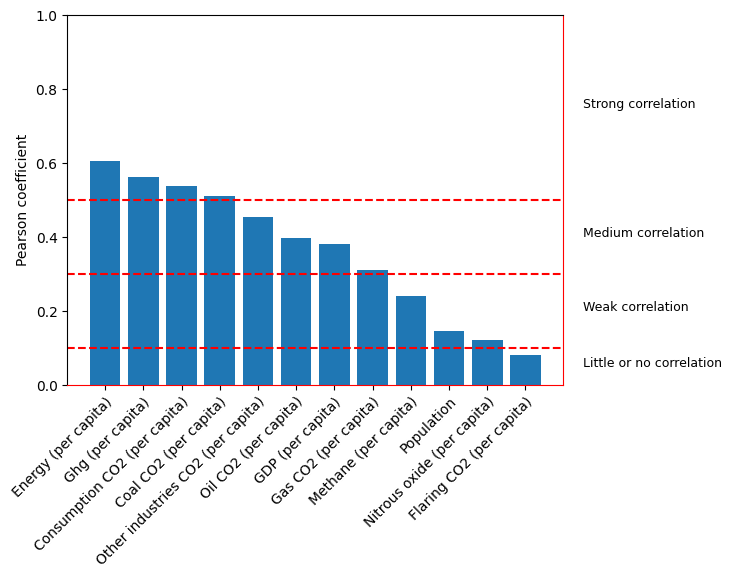

In [326]:
fig, ax = plt.subplots()

side_text_distance = len(df_pearsonr["Variable"]) + 0.5

reverence = df_pearsonr ["Variable"]
pearsonr_values = df_pearsonr["Pearsonr"]
ax.bar(reverence, pearsonr_values)
plt.xticks(rotation = 45, ha = "right", rotation_mode = "anchor")

ax.set_ylabel("Pearson coefficient")
# ax.set_title("Correlating factors for a high CO2 output")
ax.set_ylim(0,1)


plt.axhline(y=0.1, color="red", linestyle="--")  # border between little/ no correlation and weak correlation
plt.axhline(y=0.3, color="red", linestyle="--")  # border between week correlation and medium correlation
plt.axhline(y=0.5, color="red", linestyle="--")  # border between medium correlation and strong correlation
ax.spines["right"].set_color("red")
ax.spines["bottom"].set_color("red")

plt.text(side_text_distance, 0.05, "Little or no correlation", fontsize = 9)
plt.text(side_text_distance, 0.2, "Weak correlation", fontsize = 9)
plt.text(side_text_distance, 0.4, "Medium correlation", fontsize = 9)
plt.text(side_text_distance, 0.75, "Strong correlation", fontsize = 9)

plt.savefig("correlating_factors.png", transparent = False, facecolor = "white", bbox_inches = "tight")


Top 3 predicting variables.

In [327]:
# top 3 correlating factors for a high CO2 output are:
correlating_factor_1 = df_pearsonr.iloc[1, 0]
correlating_factor_2 = df_pearsonr.iloc[2, 0]
correlating_factor_3 = df_pearsonr.iloc[3, 0]
display(correlating_factor_1, correlating_factor_2, correlating_factor_3)

'Ghg (per capita)'

'Consumption CO2 (per capita)'

'Coal CO2 (per capita)'

## 2.which countries are making the biggest strides in decreasing CO2 output?

Calculating CO2 difference per country over the period all countries contributed data.

In [328]:
def co2_difference ():
    df_co2_reduction.sort_values(by="year")

    country_group = df_co2_reduction.groupby("country")
    df_co2_difference = pd.DataFrame(columns = ["Country",
                                                "CO2 difference [%]",
                                                "CO2 difference per capita [%]"
                                                ])
    country_list = df_co2_reduction.country.unique()

    for country in country_list:
        country_data = country_group.get_group(country)

        year_start = country_data["year"].iloc[0]  # Year of first measurement
        start_co2 = country_data["co2_rolling"].iloc[0]
        year_end = country_data["year"].iloc[-1]  # Year of last measurement
        pop_start = country_data["population"].iloc[0]  # population in year of first measurement
        pop_end = country_data["population"].iloc[-1]  # population in year of last measurement
        end_co2 = country_data["co2_rolling"].tail(1)  # Last meaurement for CO2 output
        difference_co2 = (end_co2 - start_co2) / end_co2 * 100  # Percentage of difference in output between the start value and the last measured value
        start_co2_capita = country_data["co2_capita_rolling"].iloc[0]  # first meaurement for CO2 output per capita
        end_co2_capita = country_data["co2_capita_rolling"].iloc[-1]  # Last meaurement for CO2 output per capita
        difference_co2_capita = (end_co2_capita - start_co2_capita) / end_co2_capita * 100  # Percentage of difference in output per capita between the start value and the last measured value
        difference_pop = (pop_end - pop_start)/ pop_end * 100  # Percentage of difference in population

        row = {"Country": country,
               "Population change [%]": difference_pop,
               "CO2 difference [%]" : difference_co2,
               "CO2 difference per capita [%]" : difference_co2_capita
               }
        df_row = pd.DataFrame(row)
        df_co2_difference = pd.concat([df_co2_difference, df_row], axis = 0)
    return(df_co2_difference)

df_co2_difference = co2_difference()

Determin top 5 best preformers for both co2 difference as for CO2 per capita difference

In [329]:
co2_difference_top_5_percentage = df_co2_difference.nsmallest(5, "CO2 difference [%]").sort_values("CO2 difference [%]", ascending = True)
co2_capita_difference_top_5_percentage = df_co2_difference.nsmallest(5, "CO2 difference per capita [%]").sort_values("CO2 difference per capita [%]", ascending = True)

Visualize top 5

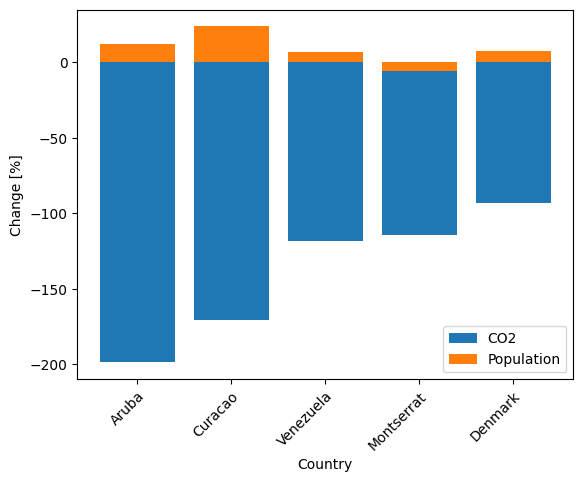

In [330]:
fig, ax = plt.subplots()
x = co2_difference_top_5_percentage["Country"]
y = co2_difference_top_5_percentage["CO2 difference [%]"]
y1 = co2_difference_top_5_percentage["Population change [%]"]
ax.bar(x,y, label = "CO2")
ax.bar(x,y1, label = "Population")
ax.set_xlabel("Country")
ax.set_ylabel("Change [%]")
# ax.set_title("Top 5 countries for CO2 reduction [%]")
ax.legend()
plt.xticks(rotation = 45, ha = "right", rotation_mode = "anchor")
plt.savefig("graph_reduction_%.png", transparent = False, facecolor = "white", bbox_inches = "tight")

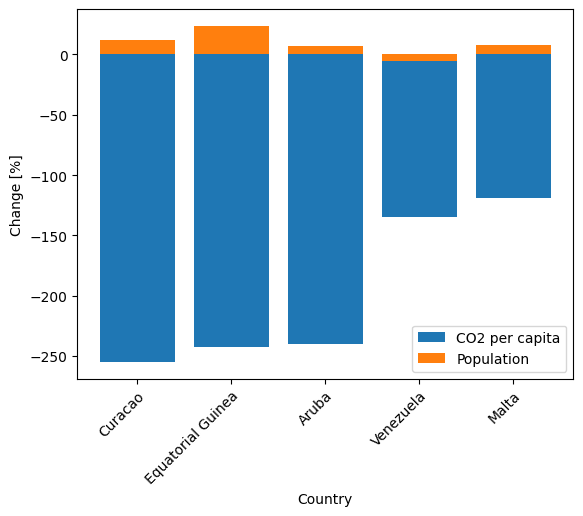

In [331]:
fig, ax = plt.subplots()
x = co2_capita_difference_top_5_percentage["Country"]
y = co2_capita_difference_top_5_percentage["CO2 difference per capita [%]"]
y1 = co2_difference_top_5_percentage["Population change [%]"]

ax.bar(x,y, label = "CO2 per capita")
ax.bar(x,y1, label = "Population")
ax.set_xlabel("Country")
ax.set_ylabel("Change [%]")
# ax.set_title("Top 5 countries for CO2 reduction per capita [%]")
ax.legend()
plt.xticks(rotation = 45, ha = "right", rotation_mode = "anchor")
plt.savefig("graph_reduction_capita_%.png", transparent = False, facecolor = "white", bbox_inches = "tight")

Determine top 3 best performing countries. (appear in both graphs)

In [332]:
best_performing = pd.merge(co2_capita_difference_top_5_percentage, co2_difference_top_5_percentage, how='inner', left_on='Country', right_on='Country')

best_performing_1 =  best_performing.iloc[0, 0]
best_performing_2 = best_performing.iloc[1,0]
best_performing_3 = best_performing.iloc[2,0]
display(best_performing_1, best_performing_2, best_performing_3)
# display(best_performing_2)

'Curacao'

'Aruba'

'Venezuela'

## 3.Which non-fossil fuel energy technology will have the best price in the future?

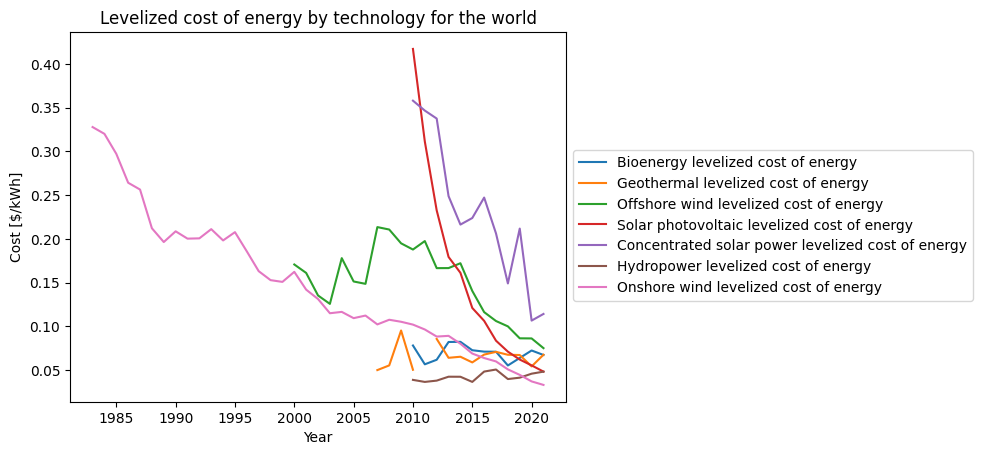

In [333]:
# visualize prices during the years
fig, ax = plt.subplots()

sources = df_energy_cost_world.columns[3:]
years = df_energy_cost_world.iloc[:,2]
values = df_energy_cost_world.iloc[:, 3:]

plt.plot(years, values)
ax.legend(sources, bbox_to_anchor = (1, 0.7))

ax.set_ylabel("Cost [$/kWh]")
ax.set_xlabel("Year")
ax.set_title(f"Levelized cost of energy by technology for the world")

plt.show()

### attempt 1 to extrapolate

In [334]:
# extrapolate data with KNNearest
def extrapolate(source):
  df_cost_extrapolated = df_energy_cost_world.copy()
  df_source = df_cost_extrapolated[["Year", source]]
  df_source = df_source.dropna()
  range_years =  range(2022,2031) # not specified how far in the future
  for y in range_years:
      row = {"Year" : [y]}
      df_row = pd.DataFrame(row)
      df_source = pd.concat([df_source, df_row], axis = 0)
      imputer = KNNImputer(n_neighbors=5) # 5 = standard value
      df_source = imputer.fit_transform(df_source)
      df_source = pd.DataFrame(df_source, columns = ["Year", source])

  return (df_source)

# produce different extrapolated dataframes
bio = (extrapolate("Bioenergy levelized cost of energy"))
geo = (extrapolate("Geothermal levelized cost of energy"))
offshore = (extrapolate("Offshore wind levelized cost of energy"))
solar_voltaic = (extrapolate("Solar photovoltaic levelized cost of energy"))
concentrated_solar = (extrapolate("Concentrated solar power levelized cost of energy"))
hydropower = (extrapolate("Hydropower levelized cost of energy"))
onshore = (extrapolate("Onshore wind levelized cost of energy"))

# merge the diffent dataframes
dataframes_sources = [bio, geo, offshore, solar_voltaic, concentrated_solar, hydropower, onshore,]
df_cost_extrapolated = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],
                                            how='outer'), dataframes_sources)

# Sort dataframe on year
df_cost_extrapolated = df_cost_extrapolated.sort_values(by = ["Year"])

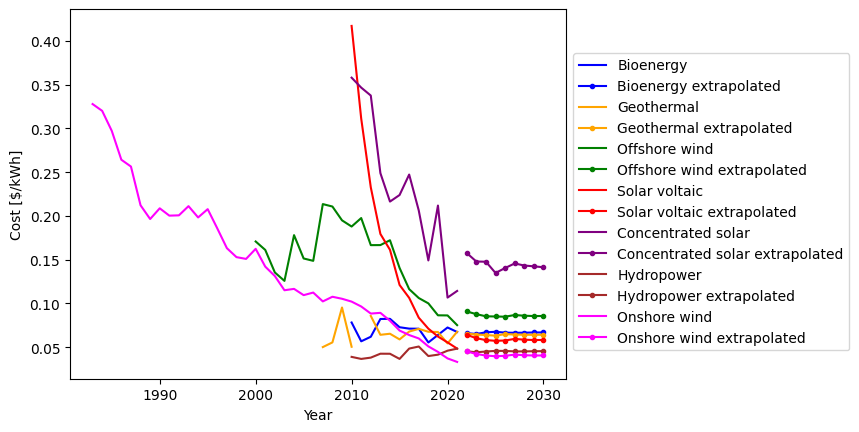

In [335]:
# visualize extrapolated prices during the years
fig, ax = plt.subplots()

original_data = df_cost_extrapolated.loc[df_cost_extrapolated["Year"] < 2022]
extrapolated = df_cost_extrapolated.loc[df_cost_extrapolated["Year"] >= 2022]

handles = ["Bioenergy", "Bioenergy extrapolated",
           "Geothermal", "Geothermal extrapolated",
           "Offshore wind", "Offshore wind extrapolated",
           "Solar voltaic", "Solar voltaic extrapolated",
           "Concentrated solar", "Concentrated solar extrapolated",
           "Hydropower", "Hydropower extrapolated",
           "Onshore wind", "Onshore wind extrapolated"]
#Bioenergy
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 1:2], "blue")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 1:2], "blue", marker = ".")
# Geothermal
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 2:3], "orange")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 2:3], "orange", marker = ".")
# Offshore wind
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 3:4], "green")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 3:4], "green", marker = ".")
# Solar voltaic
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 4:5], "red")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 4:5], "red", marker = ".")
# Concentrated solar
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 5:6], "purple")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 5:6], "purple", marker = ".")
# Hydropower
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 6:7], "brown")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 6:7], "brown", marker = ".")
# Onshore wind
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 7:8], "magenta")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 7:8], "magenta", marker = ".")

# plt.plot(years, values)
ax.legend(handles, bbox_to_anchor = (1, 0.9))

ax.set_ylabel("Cost [$/kWh]")
ax.set_xlabel("Year")
# ax.set_title(f"Levelized cost of energy by technology for the world")

plt.savefig("graph_extrapolated_costs.png", transparent = False, facecolor = "white", bbox_inches = "tight")

### attempt 2 to extrapolate

In [336]:
# find variable names
df_data = df_energy_cost_world.drop(["Entity", "Code", "Year"], axis = 1)
variables = df_data.columns

# final dataframe
df_forecast = pd.DataFrame(columns = ["Year"])

# for every variable:
for column_name in variables:
    df_energy = df_energy_cost_world[["Year",
                                      column_name]]

    # drop empty rows
    df = df_energy.dropna()

    # Determine period for extrapolation
    range_years =  range(2022,2041) # not specified how far in the future
    # Make copy of dataframe
    df1 = df.copy()
    # Add calculation columns
    df1['t-1'] = 0.00
    df1['t-2'] = 0.00
    df1['t-3'] = 0.00

    # Find index numbers for different columns
    index_column = df1.columns.get_loc(column_name)
    index_t1 = df1.columns.get_loc("t-1")
    index_t2 = df1.columns.get_loc("t-2")
    index_t3 = df1.columns.get_loc("t-3")

    # Determine column length of original dataframe
    length = len(df1)
    # Determine column length of exrapolated dataframe
    length2 = length + len(range_years)

    # Fill calculation columns
    for i in range(1,(len(df1[column_name]))):
        df1.iloc[i ,index_t1] = df1.iloc[(i-1), index_column]
        df1.iloc[i ,index_t2] = df1.iloc[(i-1), index_t1]
        df1.iloc[i ,index_t3] = df1.iloc[(i-1), index_t2]

    # Calculate interval
    xval=df1[1:length][['t-1','t-2','t-3']]
    yval=df1[1:length][[column_name]]

    # Import sklearn
    import sklearn.linear_model as skl
    # Define model
    model = skl.LinearRegression()
    model.fit(xval,yval)

    # Define prection formula
    xval1 = df1[:length][['t-1','t-2','t-3']]
    pred = model.predict(xval1)
    pred1 = pd.DataFrame(pred, columns = ['pred'])
    pred1 = pd.DataFrame(pred, columns = ['pred'])

    # Add forecast column
    forecast = column_name + ", forecast fit"
    df1[forecast] = 0.00
    # Determine index forecast column
    index_forecast = df1.columns.get_loc(forecast)

    # Add prediction values for known values
    for i in range(0,(len(pred1['pred']))):
        df1.iloc[i, index_forecast] = pred1.iloc[i, 0]

    # Extend dataframe for extrapolation
    for y in range_years:
        row = {"Year" : [y],
              "t-1" : [0.00],
              "t-2" : [0.00],
              "t-3" : [0.00],
              forecast : [0.00],
              column_name : [0.00]}
        df_row = pd.DataFrame(row)
        df1 = pd.concat([df1, df_row], axis = 0)
    # Replace first value with None to extract strange values
    df1.iloc[0, index_forecast] = None

    # Extrapolate data
    for i in range(9,(length2-3)):
        df1.iloc[(i+3), index_forecast] = model.intercept_[0] + model.coef_[0][0] * df1.iloc[(i+2), index_column] + model.coef_[0][1] * df1.iloc[(i+1), index_column] + model.coef_ [0][2] * df1.iloc[(i), index_column]
        df1.iloc[(i+3), index_column] = df1.iloc[(i+3), index_forecast]

    # Drop calculation columns and original data (keep only forecast column)
    df1.drop(['t-1','t-2','t-3', column_name],axis=1,inplace=True)

    # Add data to df_forecast
    df_forecast = pd.merge(df_forecast, df1, on = "Year", how = "outer")
    # Sort forecast to Year
    df_forecast = df_forecast.sort_values("Year")

# display(df_forecast)

Visualize forecast

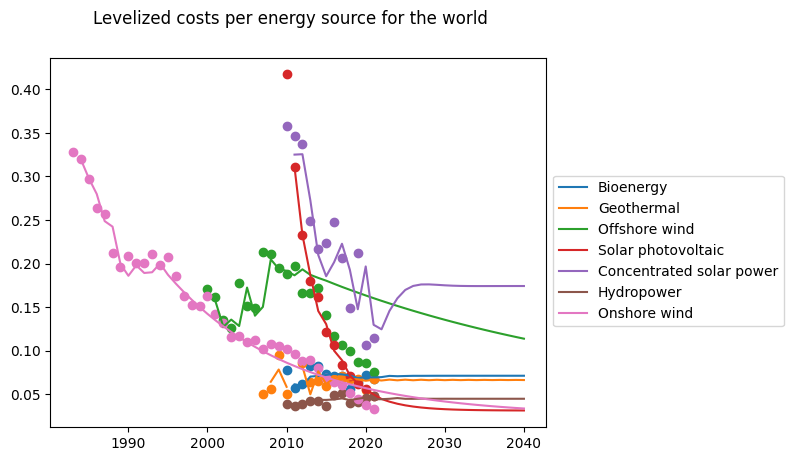

In [337]:
fig, ax = plt.subplots()

x1 = df_forecast["Year"]
y1 = df_forecast["Bioenergy levelized cost of energy, forecast fit"]
y2 = df_forecast["Geothermal levelized cost of energy, forecast fit"]
y3 = df_forecast["Offshore wind levelized cost of energy, forecast fit"]
y4 = df_forecast["Solar photovoltaic levelized cost of energy, forecast fit"]
y5 = df_forecast["Concentrated solar power levelized cost of energy, forecast fit"]
y6 = df_forecast["Hydropower levelized cost of energy, forecast fit"]
y7 = df_forecast["Onshore wind levelized cost of energy, forecast fit"]
ax.plot(x1, y1, label = "Bioenergy")
ax.plot(x1, y2, label = "Geothermal")
ax.plot(x1, y3, label = "Offshore wind")
ax.plot(x1, y4, label = "Solar photovoltaic")
ax.plot(x1, y5, label = "Concentrated solar power")
ax.plot(x1, y6, label = "Hydropower")
ax.plot(x1, y7, label = "Onshore wind")

x2 = df_energy_cost_world["Year"]
z1 = df_energy_cost_world["Bioenergy levelized cost of energy"]
z2 = df_energy_cost_world["Geothermal levelized cost of energy"]
z3 = df_energy_cost_world["Offshore wind levelized cost of energy"]
z4 = df_energy_cost_world["Solar photovoltaic levelized cost of energy"]
z5 = df_energy_cost_world["Concentrated solar power levelized cost of energy"]
z6 = df_energy_cost_world["Hydropower levelized cost of energy"]
z7 = df_energy_cost_world["Onshore wind levelized cost of energy"]

ax.scatter(x2, z1)
ax.scatter(x2, z2)
ax.scatter(x2, z3)
ax.scatter(x2, z4)
ax.scatter(x2, z5)
ax.scatter(x2, z6)
ax.scatter(x2, z7)
ax.legend(bbox_to_anchor = (1, 0.7))
fig.suptitle("Levelized costs per energy source for the world")

plt.show()

# PDF report

In [338]:
# class PDF(FPDF):
#     def header(self):
#         # Logo
#         # self.image('logo_pb.png', 10, 8, 33)
#         # Arial bold 15
#         self.set_font('Arial', 'B', 15)
#         # Move to the right
#         self.cell(80)
#         # Title
#         self.cell(30, 10, "", 0, 0, 'C')
#         # Line break
#         self.ln(20)
#     # Page footer
#     def footer(self):
#         if self.page_no() != 1:
#           # Go to 1.5 cm from bottom
#           self.set_y(-15)
#           # Select Arial italic 8
#           self.set_font('Arial', 'I', 8)
#           # Print centered page number
#           self.cell(0, 10, 'Page %s' % self.page_no(), 0, 0, 'C')

# # Origin of pdf
# pdf = PDF("P", "mm", "A4")

# # Add first page to pdf
# pdf.add_page()
# # margin
# margin = 25
# # page with (A4)
# pw = 210 - (2 * margin)
# # Cell height
# ch = 5


# # Doc title
# pdf.set_font("Arial", "B", 28)
# pdf.cell(w = 0, h = 200, txt = "CO2 emisions", ln = 2, align= "C")

# # Doc date
# pdf.set_font("Arial", "", 12)
# pdf.cell(w = pw/2, h = ch, txt = "", ln = 0)
# pdf.cell(w = pw/4, h = ch, txt = "Date:    ", ln = 0, align = "R")
# pdf.cell(w = pw/4, h = ch, txt = "19-9-2023", ln = 1)

# # Doc author
# pdf.set_font("Arial", "", 12)
# pdf.cell(w = pw/2, h = ch, txt = "", ln = 0)
# pdf.cell(w = pw/4, h = ch, txt = "Author: ", ln = 0, align = "R")
# pdf.cell(w = pw/4, h = ch, txt = "Petra Hartman", ln = 1)

# # Introduction
# pdf.add_page()
# pdf.set_font("Arial", "B", 14)
# pdf.cell(w = 0 , h = ch, txt = "Introduction", ln=1)
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = """This is a report regarding the CO2 emissions. Goal of this report is to answer the following questions:
# 1.\tWhat is the biggest predictor of a large CO2 output per capita of a country?
# 2.\tWhich countries are making the biggest strides in decreasing CO2 output?
# 3.\tWhich non-fossil fuel energy technology will have the best price in the future?

# In this report you will find the method used to achieve these results, the results and the conclusion drawn from these results.

# """)

# # Method
# pdf.set_font("Arial", "B", 14)
# pdf.cell(w = 0 , h = ch, txt = """Method""", ln=1)

# # Method 1. Biggest predictor
# pdf.set_font("Arial", "B", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = "\nWhat is the biggest predictor of a large CO2 output per capita of a country?")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""To determine the biggest predictors for a high CO2 output per capita for a country the decision is made to only use the CO2 emissions that are available per capita. Exeption is the GDP that will be converted to the GDP per capita.
# 1)\tCheck if the variables are distributed normaly with the Shapiro-Wilk test.
# 2)\tIf the variables are not distributed normaly: normalize the data.
# 3)\tDetermine the Pearson correlation coefficient and corresponding P-value for all factors versus the {df_pearsonr.iloc[0, 0]}.
# 4)\tExclude all Pearson correlation coefficients with a P-value higher than 0.05%.
# 5)\tDetermine the 3 variables that have a high correlation to the {df_pearsonr.iloc[0, 0]}. Meaning that when the variable has a high value, the {df_pearsonr.iloc[0, 0]} has a high value as well.
# """)

# # Method 2. Biggest strides in decreasing CO2 output
# pdf.set_font("Arial", "B", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = "\nWhich countries are making the biggest strides in decreasing CO2 output?")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""To determine the countries that made the biggest strides in reducing the CO2 output the decision is made to only use the relative values of CO2 emission. These emissions are exluding land-use change and emissions embedded in traded goods. This to make the data objective and insensitive for the size of the country or population of the country.
# The following steps will be taken:
# 1)\tDetermine and visualise the cummulative CO2 output and the number contributing countries.
# 2)\tDetermine the CO2 output per country. This is done by formula:
# \t\t[CO2 output] = ([CO2 output end period] - [CO2 output max value]) / [CO2 output end period] *100%.
# 3)\tDetermine the relative CO2 output per capita. This is done by formulas:
# \t\t[CO2 output per capita] = ([CO2 output] * 1000000000) / [Population].
# \t\t[Relative CO2 output per capita] = [CO2 output per capita end] - [CO2 output per capita max value] / [CO2 output per capita end] * 100
# 4)\tVisualize the best 5 performing countries of both the relative CO2 output as the relative CO2 output per capita.
# 5)\tThe countries that are in both conditions the best performing are the countries that made the biggest strides in reducing the CO2 output.
# """)

# # Method 3.
# pdf.set_font("Arial", "B", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = "\nWhich non-fossil fuel energy technology will have the best price in the future?") # Toevoegen!
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = """To determine which non-fossil fuel energy technology will have most likely the best price in the future the curernt available data for the several types of energy will be used.
# The following steps will be taken:
# 1) Extrapolate the available data of levelized energy cost (global scale) to 2030, using K-Nearest Neighbours with n = 5 (standard).
# 2) Plot the original and extrapolated data.
# 3) Determine the lowest prices in the future

# """)

# # Results header
# pdf.set_font("Arial", "B", 14)
# pdf.cell(w = 0 , h = ch, txt = "Results", ln=1)

# # Results 1. Biggest predictor.
# pdf.set_font("Arial", "B", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = "\nWhat is the biggest predictor of a large CO2 output per capita of a country?")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""At first the data is checked for the normal distrubution according to the Shapiro-Wilkes test, the results are shown in table 1.1.""")
# pdf.set_font("Arial", "", 8)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""Table 1.1: Results of the Shapiro-Wilk test.""")
# pdf.image("shapiro.png", x = 10, w=170, h=0)
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""None of the variables are distributed normally. Since this is needed for the determination of the correlation betweeen variables, the data will be normalized by use of the cube root.
# Graph 1.1 shows an example of a variable before and after normalizing.""")
# pdf.set_font("Arial", "", 8)
# pdf.image("histograms_original_normalized.png", x=10, w=80, h=0)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""Graph 1.1 Original and normalized data for coal CO2 (per capita)""")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""For the normalized data the correlation between the {df_pearsonr.iloc[0, 0]} and other variables is determined according to the Pearson correlation. The variables that have a correlation are plotted in graph 1.2.""")
# pdf.set_font("Arial", "", 8)
# pdf.image("correlating_factors.png", x=10, w=100, h=0)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""Graph 1.2 correlation with {df_pearsonr.iloc[0,0]}.""")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""The three variables with the highest correlation for predicting a high CO2 output are:
# 1) {correlating_factor_1}
# 2) {correlating_factor_2}
# 3) {correlating_factor_3}.""")

# # Results 2. Biggest strides in decreasing CO2 output
# pdf.set_font("Arial", "B", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = "\nWhich countries are making the biggest strides in decreasing CO2 output?") # toevoegen
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""First the global trend for the CO2 output is visualized in graph 2.1. For this graph the data of all countries that presented measurements was added together.""")
# pdf.set_font("Arial", "", 8)
# pdf.image("total_emission_per_year.png", x=10, w=100, h=0)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""Graph 2.1: Total output of CO2 per year and the number of contributing countries""")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""Together it is seen that the CO2 output is rising each year, even after the number of contributing countries has stabilized.
# Next the reduction per country is calculated and visualized for the best 5. In order to even out the size of the country the data is given in CO2 output per country [%] (graph 2.2) and CO2 output per capita of a country [%]""")
# pdf.set_font("Arial", "", 8)
# pdf.image("graph_reduction_%.png", x=10, w=80, h=0)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""Graph 2.2: The 5 best performing countries on CO2 reduction per capita.""")
# pdf.set_font("Arial", "", 8)
# pdf.image("graph_reduction_capita_%.png", x=10, w=80, h=0)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""Graph 2.3: The 5 best performing countries on CO2 reduction.""")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""The best performing countries in CO2 output reduction are:
#                - {best_performing_1}
#                - {best_performing_2}
#                """)

# # results 3.
# pdf.set_font("Arial", "B", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = "\nWhich non-fossil fuel energy technology will have the best price in the future?") # Toevoegen!
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = """In graph 3.1 the original and extrapolated data for the several energy technologies are plotted""")
# pdf.set_font("Arial", "", 8)
# pdf.image("graph_extrapolated_costs.png", x=10, w=100, h=0)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""Graph 3.1: Original and extrapolated data for the different energy technologies.""")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = """The three non-fossil energy technologies that have most likely the lowest price in the future are:
# 1) Onshore wind energy
# 2) Hydropower energy
# 3) Solar voltaic energy

# """)

# # Conclusion header
# pdf.set_font("Arial", "B", 14)
# pdf.cell(w = 0 , h = ch, txt = "Conclusions", ln=1)

# # Conclusion 1. Biggest predictor
# pdf.set_font("Arial", "B", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = "\nWhat is the biggest predictor of a large CO2 output per capita of a country?")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""The three variables with the highest correlation for predicting a high CO2 output are:
# 1) {correlating_factor_1}
# 2) {correlating_factor_2}
# 3) {correlating_factor_3}.
# """)

# # Conclusion 2. Biggest strides in decreasing CO2 output
# pdf.set_font("Arial", "B", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = "\nWhich countries are making the biggest strides in decreasing CO2 output?")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = f"""The best performing countries in CO2 output reduction are:
# - {best_performing_1}
# - {best_performing_2}
# """)

# # Conclusion 3.
# pdf.set_font("Arial", "B", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = "\nWhich non-fossil fuel energy technology will have the best price in the future?")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = """The three non-fossil energy technologies that have most likely the lowest price in the future are:
# 1) Onshore wind energy
# 2) Hydropower energy
# 3) Solar voltaic energy

# """)

# # Sources
# pdf.set_font("Arial", "B", 14)
# pdf.multi_cell(w = 0, h = ch,
#                txt = "Sources")
# pdf.set_font("Arial", "", 11)
# pdf.multi_cell(w = 0, h = ch,
#                txt = """https://ourworldindata.org/co2-and-greenhouse-gas-emissions
# https://github.com/owid/co2-data
# https://wikistatistiek.amc.nl/index.php/KEUZE_TOETS
# https://data-affinity.nl/statistiek/sterkte-van-een-verband-bepalen.html
# https://www.statology.org/normality-test-python/
# https://ourworldindata.org/grapher/levelized-cost-of-energy """)

# # output:
# pdf.output ("CO2_emissions.pdf", "F") # Naam aanpassen aan titel document